### Wersja poc na samym numpy

In [64]:
import numpy as np, matplotlib.pyplot as plt
from scipy.special import eval_legendre
from scipy.stats import gaussian_kde
from scipy.integrate import quad
np.random.seed(0)

In [5]:
deg = 5

def legendre(u, deg):
    """
    Ortonormalne wielomiany Legendre’a przesunięte na [0,1]:
      f_i(u) = sqrt(2i+1) * P_i(2u-1)
    Zwraca tablicę (..., deg+1)
    """
    u = np.asarray(u)
    out = [np.sqrt(2*i+1) * eval_legendre(i, 2*u - 1) for i in range(deg+1)]
    return np.stack(out, axis=-1)


def quantile_norm(x):
    ranks = x.argsort().argsort() + 1
    return ranks / (len(x) + 1)

In [22]:
deg_test = 5
u_grid   = np.linspace(0, 1, 10000)               
F        = legendre(u_grid, deg_test)             
inner = F.T @ F / len(u_grid) 
print(np.round(inner, 4))


[[ 1.0000e+00  0.0000e+00  2.0000e-04 -0.0000e+00  3.0000e-04 -0.0000e+00]
 [ 0.0000e+00  1.0002e+00  0.0000e+00  5.0000e-04  0.0000e+00  6.0000e-04]
 [ 2.0000e-04  0.0000e+00  1.0004e+00  0.0000e+00  7.0000e-04  0.0000e+00]
 [-0.0000e+00  5.0000e-04  0.0000e+00  1.0006e+00 -0.0000e+00  9.0000e-04]
 [ 3.0000e-04  0.0000e+00  7.0000e-04 -0.0000e+00  1.0008e+00  0.0000e+00]
 [-0.0000e+00  6.0000e-04  0.0000e+00  9.0000e-04  0.0000e+00  1.0010e+00]]


jest otronormalna :D

In [65]:
# Syntetyczne dane 2-D: dwa klastry na przekątnych
N = 1000
# te alfa beta dodałem aby testować bardziej złożone sytuacje szybciej
alpha = 0.8
beta = 0.3
x1 = np.concatenate([np.random.randn(N//2)*alpha - beta,
                     np.random.randn(N//2)*alpha + beta])
x2 = np.concatenate([np.random.randn(N//2)*alpha + beta,
                     np.random.randn(N//2)*alpha - beta])
X  = np.column_stack([x1, x2])


In [24]:
u1, u2 = quantile_norm(X[:,0]), quantile_norm(X[:,1])
F1, F2 = legendre(u1, deg), legendre(u2, deg)    
a       = (F1.T @ F2) / N                        
f  = legendre(np.array([u2]), deg)[0]
print("F1:", F1.shape, "F2:", F2.shape, "a:", a.shape)

F1: (1000, 6) F2: (1000, 6) a: (6, 6)


In [111]:
def E_u1_given_u2(u2_scalar, eps = 0.05):
    f = legendre(np.array([u2_scalar]), deg)[0]
    num   = sum(a[1,j]*f[j] for j in range(deg+1))
    denom = sum(a[0,j]*f[j] for j in range(deg+1))
    denom = max(denom, eps)
    return num/denom if denom > 1e-5 else np.nan
np.random.seed(0)
grid_u2  = np.linspace(0.05, 0.95, 100)
pred_u1  = np.array([E_u1_given_u2(v) for v in grid_u2])


# print("f(u2=0.5) =", legendre(np.array([0.5]), deg)[0])
# print("E_u1|u2=0.5 =", E_u1_given_u2(0.5))


In [104]:
#helper: gęstość ρ(u1,u2) z clampem dodatniości ──
def density(u1_scalar, u2_scalar, eps=0.1):
    f1 = legendre(np.array([u1_scalar]), deg)[0]
    f2 = legendre(np.array([u2_scalar]), deg)[0]
    rho = (a * np.outer(f1, f2)).sum()
    return max(rho, eps)


In [27]:
#funkcja: przybliżona odwrotna CDF -> wracamy do "surowych" jednostek
def inv_cdf(u_val, raw):
    u_val = float(u_val)
    u_val = max(0.0, min(1.0, u_val))       
    return np.quantile(raw, u_val)

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])
grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

# Empiryczne średnie dla porównania
bins        = np.digitize(X[:,1], grid_raw)
true_means  = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(grid_raw))])


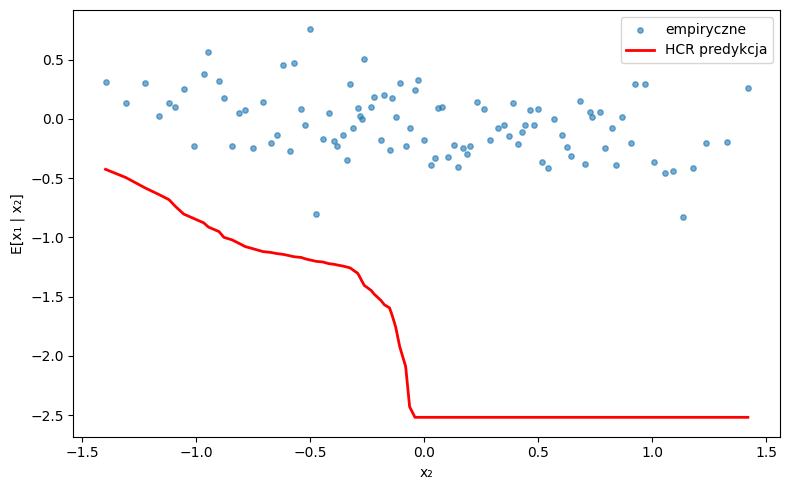

MSE warunkowych średnich ≈ 3.842


In [28]:
plt.figure(figsize=(8,5))
plt.scatter(grid_raw, true_means, s=15, alpha=0.6, label='empiryczne')
plt.plot(grid_raw, pred_raw, color='red', lw=2, label='HCR predykcja')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend(); plt.tight_layout()
plt.show()

mse = np.nanmean((pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse), 4))


mse takie sobie biorąć pod uwagę prostote tego case`u


### test podejścia robust z paperu Jarka wzór 4

In [29]:

def conditional_density_u1_given_u2(u1_grid, u2_scalar, a, deg, eps=1e-6):
    f2 = legendre(np.array([u2_scalar]), deg)[0]  
    p_joint = np.array([
        (a * np.outer(legendre(np.array([u1]), deg)[0], f2)).sum()
        for u1 in u1_grid
    ])
    p_joint = np.clip(p_joint, eps, None)
    p_joint /= np.trapz(p_joint, u1_grid)
    return p_joint

In [30]:
# u1_grid_dense = np.linspace(0, 1, 200)

# u2_values = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]  
# plt.figure(figsize=(8, 6))

# for u2_val in u2_values:
#     density_vals = conditional_density_u1_given_u2(u1_grid_dense, u2_val, a, deg)
#     plt.plot(u1_grid_dense, density_vals, label=f'u2 = {u2_val:.1f}')

# plt.title('Warynkowa gęstość p(u1|u2)')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()


In [31]:
def robust_E_u1_given_u2(u2_scalar, a, deg, eps=1e-6):
    u1_grid = np.linspace(0, 1, 200)
    cond_density = conditional_density_u1_given_u2(u1_grid, u2_scalar, a, deg, eps)
    expectation = np.trapz(u1_grid * cond_density, u1_grid)
    return expectation

grid_u2 = np.linspace(0.05, 0.95, 60)
robust_pred_u1 = np.array([robust_E_u1_given_u2(v, a, deg) for v in grid_u2])
robust_pred_u1 = np.clip(robust_pred_u1, 0, 1)

robust_pred_raw = np.array([inv_cdf(p, X[:,0]) for p in robust_pred_u1])
robust_grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

bins = np.digitize(X[:,1], robust_grid_raw)
true_means = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(robust_grid_raw))])

/tmp/ipykernel_90294/3921937127.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_joint /= np.trapz(p_joint, u1_grid)
/tmp/ipykernel_90294/3454710147.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expectation = np.trapz(u1_grid * cond_density, u1_grid)


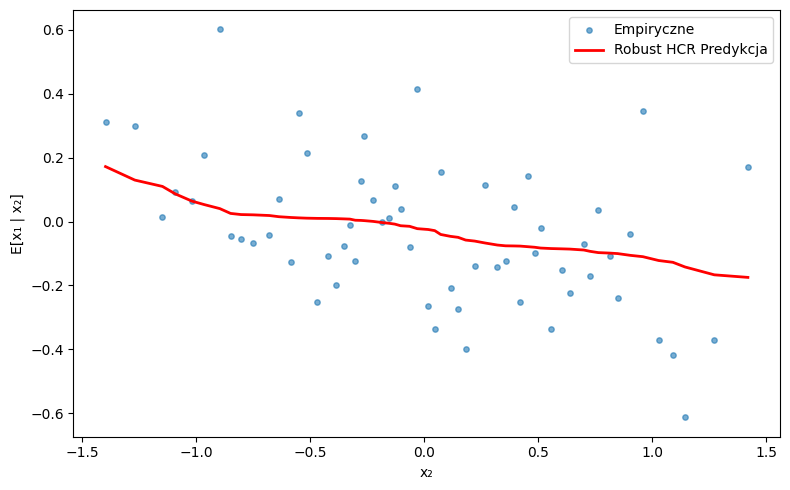

MSE warunkowych średnich ≈ 0.0406


In [32]:
plt.figure(figsize=(8,5))
plt.scatter(robust_grid_raw, true_means, s=15, alpha=0.6, label='Empiryczne')
plt.plot(robust_grid_raw, robust_pred_raw, color='red', lw=2, label='Robust HCR Predykcja')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend()
plt.tight_layout()
plt.show()
    
mse_robust = np.nanmean((robust_pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse_robust), 4))


### test bazy kosinusowej

In [33]:
deg = 4
def cosine_basis(u, deg):
    u = np.array(u)
    output = [np.ones_like(u)]
    for j in range(1, deg+1): 
        output.append(np.sqrt(2) * np.cos(np.pi * j * u))
    return np.stack(output, axis=-1) # pamiętaj o axis = -1 inaczej nie jest to ortonormalne 

In [34]:
u = np.linspace(0,1,1000)
F_cos = cosine_basis(u, deg)
ortho_check = F_cos.T @ F_cos / len(u)
print(np.round(ortho_check, 4))

[[ 1.      0.      0.0014 -0.      0.0014]
 [ 0.      1.001  -0.      0.002   0.    ]
 [ 0.0014 -0.      1.001   0.      0.002 ]
 [-0.      0.002   0.      1.001   0.    ]
 [ 0.0014  0.      0.002   0.      1.001 ]]


jest ortonotmalna :D

In [35]:
u1, u2 = quantile_norm(X[:,0]), quantile_norm(X[:,1])
F1, F2 = cosine_basis(u1, deg), cosine_basis(u2, deg)    
a       = (F1.T @ F2) / N                        
f  = cosine_basis(np.array([u2]), deg)[0]
print("F1:", F1.shape, "F2:", F2.shape, "a:", a.shape)

F1: (1000, 5) F2: (1000, 5) a: (5, 5)


In [36]:
def cosine_E_u1_given_u2(u2_scalar, eps = 0.05):
    f = cosine_basis(np.array([u2_scalar]), deg)[0]
    num   = sum(a[1,j]*f[j] for j in range(deg+1))
    denom = sum(a[0,j]*f[j] for j in range(deg+1))
    denom = max(denom, eps)
    return num/denom if denom > 1e-5 else np.nan

grid_u2  = np.linspace(0, 1, 100)
pred_u1  = np.array([cosine_E_u1_given_u2(v) for v in grid_u2])

In [37]:
def inv_cdf(u_val, raw):
    u_val = float(u_val)
    u_val = max(0.0, min(1.0, u_val))       
    return np.quantile(raw, u_val)

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])
grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

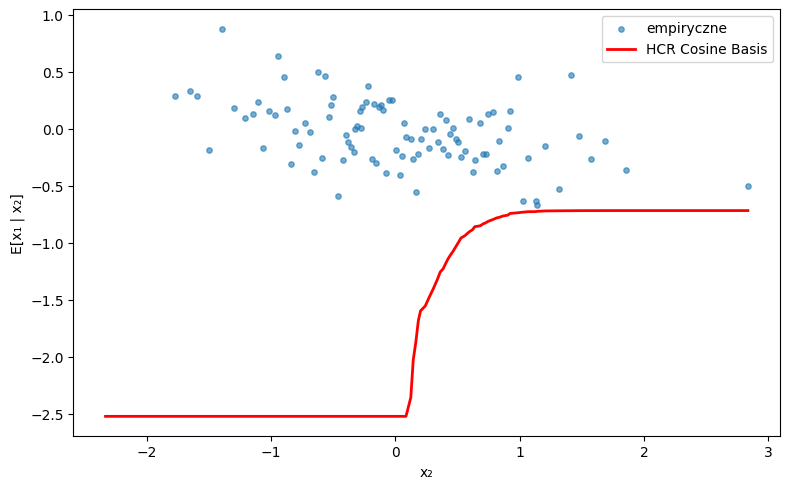

MSE warunkowych średnich ≈ 4.1169


In [38]:
bins = np.digitize(X[:,1], grid_raw)
true_means = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(grid_raw))])

plt.figure(figsize=(8,5))
plt.scatter(grid_raw, true_means, s=15, alpha=0.6, label='empiryczne')
plt.plot(grid_raw, pred_raw, color='red', lw=2, label='HCR Cosine Basis')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend(); plt.tight_layout()
plt.show()

mse = np.nanmean((pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse), 4))


### KDE

In [66]:
# normalizacja kwantylowa do [0,1]
u1, u2 = quantile_norm(X[:,0]), quantile_norm(X[:,1])

In [67]:
points = np.vstack([u1, u2])
joint_kde = gaussian_kde(points) # laczna gestość p(u1, u2)
u2_kde = gaussian_kde(u2) # gestosc brzegowa p(u2)

**Uwaga:**  
Funkcja `gaussian_kde` z `scipy.stats` automatycznie dobiera szerokość jądra (bandwidth) według **reguły Scotta**:

$$
h = \sigma \cdot n^{-1 / (d + 4)}
$$

gdzie:
- h — szerokość jądra (bandwidth),
- $ \sigma $ — oszacowana odchylenie standardowe danych,
- n  — liczba próbek,
- d — liczba wymiarów.

In [68]:
print(f"Automatycznie dobrana szerokość jądra dla rozkładu łącznego {joint_kde.factor:4f}")
print(f"Automatycznie dobrana szerokość jądra dla rozkładu brzegowego u2 {u2_kde.factor:4f}")

Automatycznie dobrana szerokość jądra dla rozkładu łącznego 0.316228
Automatycznie dobrana szerokość jądra dla rozkładu brzegowego u2 0.251189


In [69]:
def conditional_density_kde(u1, u2_value, joint_kde, u2_kde):
    # oblicza gestosc warunkowa p(u1|u2=u2_val) = p(u1,u2_val)/p(u2_val)
    return joint_kde(np.vstack([u1, np.full_like(u1, u2_value)])) / u2_kde(u2_value)

def conditional_expectation_kde(u2_value, joint_kde, u2_kde, u1_min=0, u1_max=1):
    # oblicza E[u1|u2=u2_val] używając KDE
    numerator, _ = quad(
        lambda u1: u1 * conditional_density_kde(u1, u2_value, joint_kde, u2_kde),
        u1_min, u1_max
    )
    denominator, _ = quad(
        lambda u1: conditional_density_kde(u1, u2_value, joint_kde, u2_kde),
        u1_min, u1_max
    )
    return numerator / denominator if denominator > 1e-10 else np.nan

tu pewnie przydałoby się zamiast quad całkowanie kwadraturami prostakatow lub trapezow dla stabilnosci numerycznej

In [70]:
def inv_cdf(u_val, raw):
    u_val = float(u_val)
    u_val = max(0.0, min(1.0, u_val)) #clip 0,1
    return np.quantile(raw, u_val) #odwrotna CDF

In [71]:
grid_u2  = np.linspace(0, 1, 100)
u1_grid = np.linspace(0, 1, 500)
kde_pred_u1 = np.array([conditional_expectation_kde(v, joint_kde, u2_kde) for v in grid_u2])
kde_pred_raw = np.array([inv_cdf(p, X[:,0]) for p in kde_pred_u1])
kde_grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

In [72]:
kde_bins = np.digitize(X[:,1], kde_grid_raw)
kde_true_means = np.array([
    X[:,0][bins==i].mean() if (bins==i).sum() > 0 else np.nan
    for i in range(len(kde_grid_raw))
])

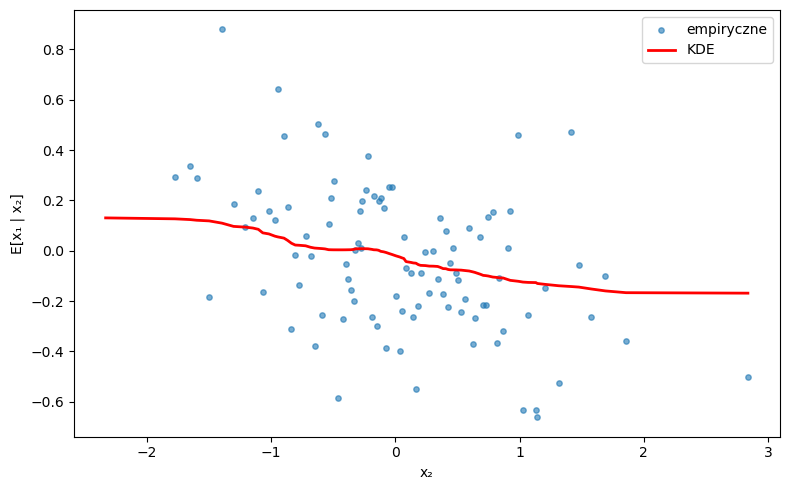

MSE warunkowych średnich ≈ 0.0687


In [73]:
plt.figure(figsize=(8,5))
plt.scatter(kde_grid_raw, kde_true_means, s=15, alpha=0.6, label='empiryczne')
plt.plot(kde_grid_raw, kde_pred_raw, color='red', lw=2, label='KDE')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend(); plt.tight_layout()
plt.show()

kde_mse = np.nanmean((kde_pred_raw - kde_true_means)**2)
print("MSE warunkowych średnich ≈", round(float(kde_mse), 4))

cool wynik zblizony do podejscia robust wyzej

In [33]:
u_points = np.vstack([u1, u2]) 
log_probs = np.log(joint_kde(u_points))
log_likelihood_kde = np.mean(log_probs)

print("log-likelihood dla KDE:", round(log_likelihood_kde, 4))

log-likelihood dla KDE: -0.1487


#### test innych szerokosci jader

In [ ]:
#aproksymacja warunkowej wartosci oczekiwanej z calkowaniem numerycznym dla stabilnosci
def conditional_expectation_kde_approx(u2_value, joint_kde, u2_kde, u1_min=0, u1_max=1, n_points=1000):
    u1_grid = np.linspace(u1_min, u1_max, n_points)
    dens_vals = conditional_density_kde(u1_grid, u2_value, joint_kde, u2_kde)
    numerator = np.sum(u1_grid * dens_vals)
    denominator = np.sum(dens_vals)
    if denominator < 1e-10:
        return np.nan
    else:
        return numerator / denominator

In [96]:
bandwidths = np.linspace(0.01, 0.05, 20)
log_likelihoods = []
mse_values = []

for bw in bandwidths:
    #print(f'Procesowanie szerokosci jadra: {bw:4f}')
    joint_kde = gaussian_kde(points, bw_method=bw)
    u2_kde = gaussian_kde(u2, bw_method=bw)

    log_probs = np.log(joint_kde(points))
    log_likelihoods.append(np.mean(log_probs))

    kde_pred_u1 = np.array([
    conditional_expectation_kde_approx(v, joint_kde, u2_kde) for v in grid_u2])

    kde_pred_raw = np.array([inv_cdf(p, X[:,0]) for p in kde_pred_u1])

    mse = np.nanmean((kde_pred_raw - kde_true_means)**2)
    mse_values.append(mse)


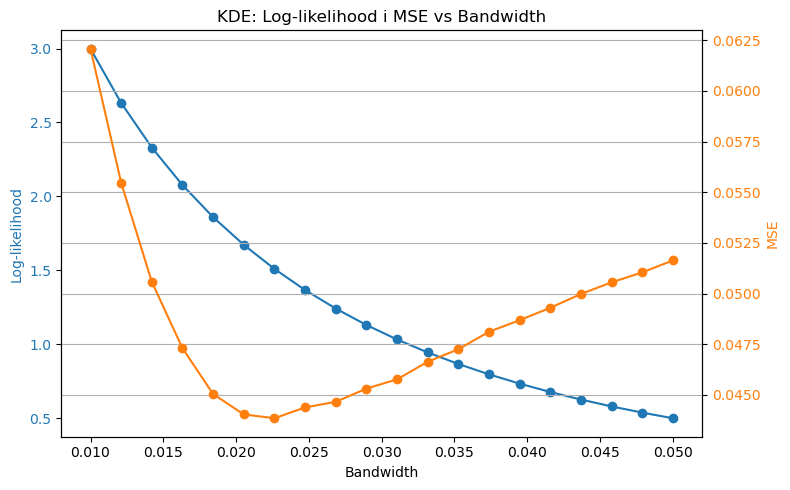

In [97]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel("Bandwidth")
ax1.set_ylabel("Log-likelihood", color=color1)
ax1.plot(bandwidths, log_likelihoods, marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel("MSE", color=color2)
ax2.plot(bandwidths, mse_values, marker='o', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("KDE: Log-likelihood i MSE vs Bandwidth")
plt.tight_layout()
plt.grid(True)
plt.show()
